In [ ]:
import pickle
import numpy as np
from nilearn.image import load_img, new_img_like
import nilearn.plotting as plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
import scipy
import resting_state_summaries as rss

from nilearn import image, plotting
underlay = image.load_img('MNI152_2009_template.nii.gz')

from PIL import Image,ImageChops
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    #Bounding box given as a 4-tuple defining the left, upper, right, and lower pixel coordinates.
    #If the image is completely empty, this method returns None.
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

atlas = load_img('Schaefer2018_200Parcels_17Networks_order_FSLMNI152_2mm.nii.gz')
def vec_to_img(vec):
    n_rois = 200
    atlas_data = atlas.get_fdata()

    vec_img_data = np.zeros_like(atlas_data)
    for idx_roi in range(n_rois):
        vec_img_data += (atlas_data==idx_roi+1) * vec[idx_roi]

    vec_img = new_img_like(data=vec_img_data, ref_niimg=atlas)
    return vec_img

In [ ]:
K = 6
D = 10
with open('Final_model/K6_D10_500subjs_compact_model.pkl', 'rb') as f:
    [model, q, elbos, q_z] = pickle.load(f)

num_roi = model.N
num_subject = len(np.unique(model.tags))
pid = np.unique(model.tags)

In [52]:
with open('summary_data/roi_activity_evolution.pkl', 'rb') as f:
    activity_evolution = pickle.load(f)
with open('summary_data/roi_activity_evolution_subject.pkl','rb') as f:
     activity_evolution_subject = pickle.load(f)

In [3]:
with open('summary_data/state_duration.pkl', 'rb') as f:
    state_duration = pickle.load(f)
with open('summary_data/state_order.pkl','rb') as f:
    state_order = pickle.load(f)

In [4]:
# define state colors for paper
state_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][0:6]

Figure 3: PCC-activity-time

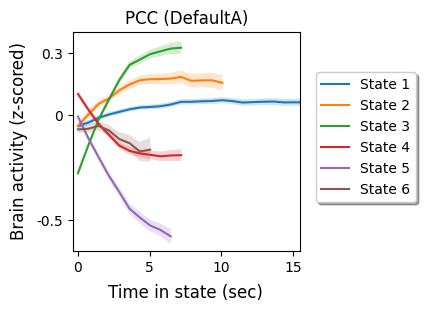

In [ ]:
roi_id = 77-1
roi_label = 'PCC (DefaultA)'

fig, axs = plt.subplots(figsize = (3,3),  layout='constrained')
ax = axs

for k in range(K):
    state = state_order[k]
    late_time = state_duration[state]+3
    mean_evolution = activity_evolution[state][roi_id+54][0:(late_time + 1)]
    ax.plot(mean_evolution, label = 'State %s'%(k+1), color = state_colors[k])

    se = np.zeros(len(mean_evolution))
    for t in range(len(mean_evolution)):
        vec = [activity_evolution_subject[s][state][roi_id+54][t] for s in range(num_subject)]
        se[t] = np.nanstd(vec)/np.sqrt(num_subject-np.sum(np.isnan(vec)))
    lower = mean_evolution-2*se
    upper = mean_evolution+2*se
    ax.fill_between(np.arange(len(se)), lower, upper, alpha=0.2, facecolor = state_colors[k])

ax.set_xlim(0,10)
ax.set_ylim(-.65, .4)
ax.set_yticks([-0.5, 0, .3], ['-0.5', '0','0.3'])
ax.set_title(roi_label, fontsize = 12)

label_times = [0,5,10,15] 
xticks = [label_times[i]/0.72 for i in range(len(label_times))] # in TR
ax.set_xticks(xticks, label_times)
ax.set_xlim(-0.5, 21 + 0.5)

fig.supxlabel('Time in state (sec)', fontsize = 12, x=0.6)
fig.supylabel('Brain activity (z-scored)', fontsize = 12, y = 0.55)

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.2, 0.8),
            fancybox=True, shadow=True, fontsize = 10, handlelength=2)

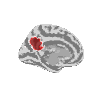

In [ ]:
vec = np.zeros(200)
vec[76] = 1
vec_img = vec_to_img(vec)
fig,ax = plotting.plot_img_on_surf(
                        vec_img,
                        surf_mesh='fsaverage5', bg_on_data=True, inflate=True,
                        hemispheres=['left'], views=['medial'],
                        vmin = -.5, vmax=0.5, 
                        threshold=1e-10,
                        colorbar=False,
                        cmap = 'seismic'
                    )
fig.set_size_inches(1, 1)

Figure 4: cosine similarity with attractor, temporal

In [265]:
C = model.emissions.Cs[0]
d = model.emissions.ds[0]
roi_attractor = []
for k in range(K): 
    attractor = np.linalg.inv(np.identity(D)- model.parent.dynamics.As[k]).dot(model.parent.dynamics.bs[k])
    roi_attractor.append(C.dot(attractor) + d)

In [266]:
cs_train = np.zeros((K, 30))
for k in range(K):
    for t in range(30):
        cs_train[k,t] = rss.cosine_similarity(roi_attractor[k], [activity_evolution[k][j][t] for j in range(num_roi)])

In [262]:
roi_attractor_subject = dict()
for s in range(num_subject):
    roi_attractor_subject[s] = []
    for k in range(K): 
        attractor = np.linalg.inv(np.identity(D)- model.children[pid[s]].dynamics.As[k]).dot(model.children[pid[s]].dynamics.bs[k])
        roi_attractor_subject[s].append(C.dot(attractor)+d)
        
cs_train_subject = np.zeros((num_subject, K, 30))
for s in range(num_subject):
    for k in range(K):
        for t in range(30):
            cs_train_subject[s,k,t] = rss.cosine_similarity(roi_attractor_subject[s][k], [activity_evolution_subject[s][k][j][t] for j in range(num_roi)])

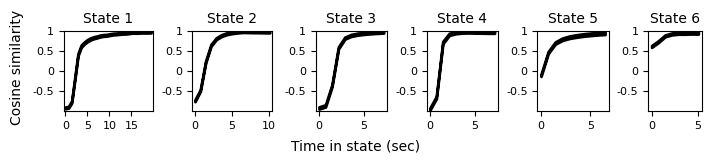

In [ ]:
available_subjects = dict()
fig, axs = plt.subplots(ncols = K, figsize = (7,1.5), width_ratios= [5,4.5,4,4,4,3], layout = 'constrained')
for k in range(K):
    ax = axs[k]
    state = state_order[k]
    late_time = state_duration[state]+3
    y = cs_train[state, 0:(late_time+1)]
    available_subjects[k] = np.zeros(len(y)) 
    se = np.zeros(len(y))
    for t in range(len(y)):
        vec = [cs_train_subject[s, state, t] for s in range(num_subject)]
        available_subjects[k][t] = num_subject-np.sum(np.isnan(vec))
        se[t] = np.nanstd(vec)/np.sqrt(available_subjects[k][t])
    lower = y-2*se
    upper = y+2*se
    ax.fill_between(np.arange(len(se)), lower, upper, facecolor = 'black', edgecolor = 'black', linewidth = 2)
    ax.set_ylim(-1,1)
    ax.set_yticks([-0.5,0,0.5,1], [-0.5,0,0.5,1], fontsize = 8)
    
    label_times = [0,5,10,15] 
    xticks = [label_times[i]/0.72 for i in range(len(label_times))] # in TR
    ax.set_xticks(xticks, label_times, fontsize = 8)
    ax.set_xlim(-0.5, late_time+0.5)
    
    ax.set_title('State %s'%(k+1), fontsize = 10)

fig.supxlabel('Time in state (sec)', fontsize = 10)
fig.supylabel('Cosine similarity', fontsize = 10, y = 0.6)

Figure 5: cosine similarity between states

In [5]:
late_map = np.zeros((K,num_roi))
for k in range(K):
    T = state_duration[k]+3
    for i in range(num_roi):
        late_map[k,i] = activity_evolution[k][i][T]

In [7]:
cs_late_pt = np.zeros((K, K))
for k1 in range(K):
    for k2 in range(K):
        cs_late_pt[k1,k2] = rss.cosine_similarity(late_map[state_order[k1]], late_map[state_order[k2]])

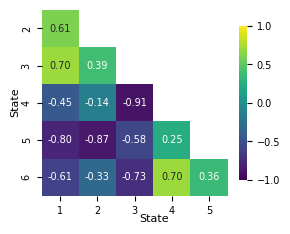

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(3,2.5))

mat = cs_late_pt
y_axis_labels = ['%s'%(k+1) for k in range(K)]
x_axis_labels = ['%s'%(k+1) for k in range(K)] 
mask = np.triu(np.ones_like(mat, dtype=bool), k=0)

data_trimmed = mat[1:, :-1]
mask_trimmed = mask[1:, :-1]

sns.heatmap(data_trimmed, vmin = -1, vmax = 1, square=True, annot=True, fmt='.2f', annot_kws={'size':7}, mask=mask_trimmed , 
            cbar = True, cbar_kws={"shrink": 0.8},
            cmap='viridis',
           xticklabels=x_axis_labels[:-1], yticklabels=y_axis_labels[1:])

axs.tick_params(axis='y', labelsize=7)   
axs.tick_params(axis='x', labelsize=7)

cbar = axs.collections[0].colorbar
cbar.ax.tick_params(labelsize=7) 

fig.supxlabel('State', fontsize = 8)
fig.supylabel('State', fontsize = 8)

Figure 6: state statistics

Panel A: state duration

In [49]:
with open('data/roi_timeseries_rsfMRI_HCP_held_out', 'rb') as f:
    datas = pickle.load(f)
with open('data/tags_rsfMRI_HCP_held_out', 'rb') as f:
    tags = pickle.load(f)

In [50]:
y_subject = dict()
z_subject = dict()
for s in range(num_subject):
    subject_data = [datas[i] for i in range(len(datas)) if tags[i] == pid[s]]  
    y_subject[s] = np.concatenate(subject_data)
    z_subject[s] = [q_z[i] for i in range(len(datas)) if tags[i] == pid[s]]

In [51]:
z_bundle_subject = dict()
y_bundle_subject = dict()
for s in range(num_subject):
    z_bundle_subject[s] = rss.collect_z_bundle(z_subject[s])
    y_bundle_subject[s] = rss.collect_y_bundle(y_subject[s], z_bundle_subject[s], K)

In [52]:
y_bundles = dict()
for k in range(K):
    y_bundles[k] = []
    for s in range(num_subject):
        for j in range(len(y_bundle_subject[s][k])):
            y_bundles[k].append(y_bundle_subject[s][k][j])

In [53]:
lifetimes = []
for k in range(K):
    lifetimes.append([y_bundles[k][i].shape[0]*0.72 for i in range(len(y_bundles[k]))])

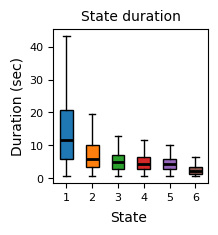

In [ ]:
fig, axs = plt.subplots(figsize = (2,2))
bp = plt.boxplot([lifetimes[state_order[k]] for k in range(K)], patch_artist=True, showfliers=False)
plt.ylabel('Duration (sec)', fontsize = 10)
plt.yticks([0,10,20,30,40], fontsize = 8)
plt.xticks(fontsize = 8)
plt.title('State duration', fontsize = 10)
for patch, color in zip(bp['boxes'], state_colors):
    patch.set_facecolor(color)
for median in bp['medians']:
    median.set_color('black')
    median.set_linewidth(2)
fig.supxlabel('State', fontsize = 10, y = -0.1)
plt.show()

Panel B: state probability

In [ ]:
ps = rss.compute_state_probability(q_z, K)
ps_subject = dict()
for s in range(num_subject):
    qz = [q_z[i] for i in range(len(datas)) if tags[i] == pid[s]]
    ps_subject[s] =  rss.compute_state_probability(qz, K)

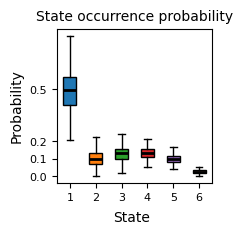

In [ ]:
fig, axs = plt.subplots(figsize = (2,2))
ps_boxplot = [[ps_subject[s][state_order[k]] for s in range(num_subject)] for k in range(K)]
bp = plt.boxplot(ps_boxplot, patch_artist=True, showfliers=False)
plt.yticks([0, 0.1, 0.2, 0.5], fontsize = 8)
plt.xticks(fontsize = 8)
plt.ylabel('Probability', fontsize = 10)
plt.title('State occurrence probability', fontsize = 10)
for patch, color in zip(bp['boxes'], state_colors):
    patch.set_facecolor(color)
for median in bp['medians']:
    median.set_color('black')
    median.set_linewidth(2)
fig.supxlabel('State', fontsize = 10, y = -0.1)
plt.show()

Panel C: occurrence probability in run

In [ ]:
# compute occurrence pmf from collection of state sequences, i.e., a pmf over {1,2,...,K} for each time point of the run
# need to make sure all runs have the same time length, otherwise occurrence pmf is not well defined.
def compute_occurence(q_z, k):
    occurence = np.zeros(1200)
    for i in range(len(q_z)):
        for t in range(1200):
            if q_z[i][t] == k:
                occurence[t] += 1
    occurence = occurence/len(q_z)
    return occurence

In [129]:
# use all runs that have 1200 time steps
# 1987 qualifiers out of 2000 from our held-out data
count_num_run = 0
run_id = []
for i in range(len(q_z)):
    if len(q_z[i]) == 1200:
        count_num_run += 1
        run_id.append(i)

In [ ]:
# quantify uncertainty using standard error across subjects 
occurrence_pmf_subj = np.zeros((500, K, 1200))
for s in range(500):
    for k in range(K):
        occurrence_pmf_subj[s,k,:] = compute_occurence([q_z[s*4+i] for i in range(4) if (s*4+i) in run_id], k)

In [131]:
mean_occurrence_across_subj = np.mean(occurrence_pmf_subj, axis = 0)
se_occurrence_across_subj = np.std(occurrence_pmf_subj, axis = 0)/np.sqrt(500)

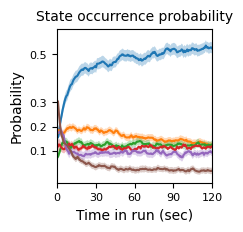

In [ ]:
fig, axs = plt.subplots(figsize = (2,2))
ax = axs
for k in range(K):
    ax.plot(mean_occurrence_across_subj[state_order[k],:])
    lower = mean_occurrence_across_subj[state_order[k],:] -2*se_occurrence_across_subj[k,:]
    upper = mean_occurrence_across_subj[state_order[k],:] + 2*se_occurrence_across_subj[k,:]
    ax.fill_between(np.arange(1200), lower, upper, alpha=.3)
#ax.legend()
ax.set_xlabel('Time in run (sec)', fontsize = 10)
ax.set_ylabel('Probability', fontsize = 10)
plt.title('State occurrence probability', fontsize = 10)
#ax.set_ylim(0, 0.6)
xticklabels = [0, 30, 60, 90, 120] # in seconds
xticks = [xticklabels[i]/0.72 for i in range(len(xticklabels))] # in TR
ax.set_xlim(0,xticks[len(xticks)-1])
plt.yticks([0.1, 0.2, 0.3, 0.5], fontsize = 8)
plt.xticks(xticks, fontsize = 8)
ax.set_xticklabels(xticklabels)
plt.show()

Figure 6: transition probabilities

In [147]:
P = rss.compute_transition_mat(q_z, K)
exit_P = rss.exit_transition(P)

In [ ]:
B = 1000
z_score = np.zeros((num_subject, K, K))
transition_mats = []
exit_transition_mats = []
for s in range(num_subject):
    qz_subject = [q_z[i] for i in np.where(np.array(model.tags) == pid[s])[0]]
    transition_mats.append(rss.compute_transition_mat(qz_subject, K))
    exit_transition_mats.append(rss.exit_transition(transition_mats[s]))
    null_transition_mats = []
    for b in range(B):
        qz = qz_subject.copy()
        for rid in range(len(qz)):
            zs = qz[rid]
        
            # create state bundles
            z_bundle = []
            current_state = -1
            for i in range(len(zs)):
                if i == 0: 
                    current_state = zs[i]
                    current_lifetime = 1
                elif zs[i] == current_state:
                    current_lifetime += 1 
                else: 
                    z_bundle.append(np.repeat(current_state, current_lifetime)) 
                    current_state = zs[i]
                    current_lifetime = 1
                if i == len(zs)-1:
                    z_bundle.append(np.repeat(current_state, current_lifetime)) 
                    current_lifetime = 0
            
            # permute state bundles
            np.random.shuffle(z_bundle)
            qz[rid] = np.concatenate(z_bundle)

        null_transition_mats.append(rss.compute_transition_mat(qz, K))

    null_exit_transition_mats = []
    for b in range(B):
        null_exit_transition_mats.append(rss.exit_transition(null_transition_mats[b]))
    mu = np.mean(null_exit_transition_mats, axis = 0)
    sigma = np.std(null_exit_transition_mats, axis = 0, ddof=1)
    z_score[s,:,:] = (exit_transition_mats[s] - mu) / sigma

In [ ]:
pvalue_mat = np.zeros((K,K))
mu_0 = 0
for i in range(K):
    for j in range(K):
        if j!=i:
                scores = z_score[:,i,j]
                N = num_subject-np.sum(np.isnan(scores))
                test_statistics = np.sqrt(N)*(np.nanmean(scores)-mu_0)/np.nanstd(scores)
                df = N-1
                pvalue_mat[i,j] = scipy.stats.t.sf(test_statistics, df)

In [ ]:
transition_mat_rejection = np.zeros((K,K))
for i in range(K):
    for j in range(K):
        if (j!=i) & (pvalue_mat[state_order[i],state_order[j]] < 0.05/((K-1)*K)): # bonferroni correction
            transition_mat_rejection[i,j] = 1

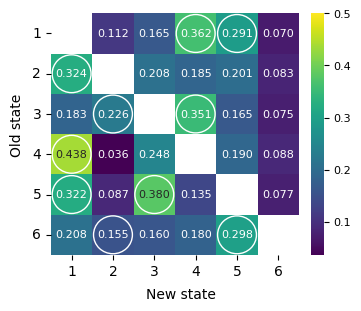

In [ ]:
fig = plt.figure(figsize=(3.5, 3), layout = 'constrained')
ax = fig.add_subplot()
mask = np.zeros_like(exit_P, dtype=bool)
np.fill_diagonal(mask, True)
sns.heatmap(
    rss.permute_matrix(exit_P, state_order),
    annot=True, fmt='.3f', annot_kws={'size': 8}, 
    mask = mask,
    cmap='viridis',
    vmax = .5,
    ax=ax)

ax.set_xticklabels([f'{i+1}' for i in range(K)], rotation=0, fontsize=12)
ax.set_yticklabels([f'{i+1}' for i in range(K)], rotation=0, fontsize=12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

for i in range(K):
    for j in range(K):
        if (j!=i) & (transition_mat_rejection[i,j] == 1):
            ax.add_patch(
                patches.Circle((j+0.5,i+0.5), 0.47, linewidth=1, edgecolor='white',facecolor='none')
            )

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=8) 

fig.supxlabel('New state', fontsize=10)
fig.supylabel('Old state', fontsize=10, y = 0.6)

Figure 8: network activity time cortex

In [16]:
cortex_groups = [[1,2,3,4,5,6, 101, 102, 103, 104, 105, 106], 
                 [7,8,9,10,11,12,107, 108, 109, 110, 111, 112], 
                 [13,14,15,16,17,18,19,20,113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123], 
                 [21, 22, 23, 24, 25, 26, 27, 28,124, 125, 126, 127, 128, 129, 130],
                 [29, 30, 31, 32, 33, 34,131, 132, 133, 134, 135, 136],
                 [35, 36, 37, 38, 39,137, 138, 139, 140, 141],
                 [40, 41, 42, 43, 44, 45, 46,142, 143, 144, 145, 146, 147, 148, 149, 150],
                 [47, 48, 49, 50,151, 152, 153, 154, 155, 156],
                 [51,52,157, 158, 159, 160],
                 [53, 54, 55, 56,161, 162, 163, 164],
                 [57, 58, 59, 60, 61, 62, 63, 64, 65, 66,165, 166, 167, 168, 169, 170],
                 [67, 68, 69, 70, 71,171, 172, 173, 174, 175, 176, 177, 178, 179, 180],
                 [72, 73, 74,181, 182, 183],
                 [75, 76, 77, 78, 79, 80, 81, 82,184, 185, 186, 187, 188, 189], 
                 [83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95,190, 191, 192, 193], 
                 [96, 97, 98,194, 195, 196],
                 [99,100,197, 198, 199, 200]]
for g in range(len(cortex_groups)):
    cortex_groups[g] = [cortex_groups[g][i]+54 for i in range(len(cortex_groups[g]))]
cortex_key_labels = ['VisCent','VisPeri','SomMotA','SomMotB','DorsAttnA','DorsAttnB', 'SalVentAttnA',
             'SalVentAttnB','LimbicB','LimbicA','ContA','ContB','ContC','DefaultA','DefaultB',
             'DefaultC','TempPar']
cortex_keys = np.cumsum([len(cortex_groups[g]) for g in range(len(cortex_groups))])[0:16]
cortex_keys = np.append(0, cortex_keys)
for g in range(len(cortex_groups)):
    cortex_groups[g] =  np.array(cortex_groups[g], dtype = int)-1

In [56]:
def compute_auc(activity_evolution, T = 5): # use T=5 for initial response
    num_roi = len(activity_evolution)
    auc = np.zeros(num_roi)
    for j in range(num_roi):
        auc[j] = np.mean(activity_evolution[j][1:(T+1)])-activity_evolution[j][0]
    return auc

In [57]:
state_auc = np.zeros((K, num_roi))
for k in range(K):
    state = state_order[k]
    state_auc[k,:] = compute_auc(activity_evolution[state])

In [ ]:
state_auc_network = np.zeros((K,17))
for k in range(K):
    for i in range(17):
        state_auc_network[k,i] = np.mean(state_auc[k, cortex_groups[i]])

In [17]:
network_evolution = dict()
network_evolution_subject = dict()
for s in range(num_subject):
    network_evolution_subject[s] = dict()
for k in range(K):
    network_evolution[k] = [np.mean([activity_evolution[k][j] for j in cortex_groups[i]], axis = 0) for i in range(len(cortex_groups))]
    for s in range(num_subject):
        network_evolution_subject[s][k] = [np.mean([activity_evolution_subject[s][k][j] for j in cortex_groups[i]], axis = 0) for i in range(len(cortex_groups))] 

In [ ]:
state_auc_network_subject = np.zeros((num_subject, K, 17))
for s in range(num_subject):
    state_auc_subject = np.zeros((K, num_roi))
    for k in range(K):
        state = state_order[k]
        state_auc_subject[k,:] = compute_auc(activity_evolution_subject[s][state], T = state_duration[state])
    for k in range(K):
        for i in range(17):
            state_auc_network_subject[s,k,i] = np.mean(state_auc_subject[k, cortex_groups[i]])

mu_0 = 0
pvalues = np.zeros((K, len(cortex_groups)))
test_stats = np.zeros((K, len(cortex_groups)))
for k in range(K):
    for i in range(len(cortex_groups)):
        vec = [state_auc_network_subject[s][k,i] for s in range(num_subject)]
        N = num_subject-np.sum(np.isnan(vec))  # number of subjects which have state k trajectories until mean duration (so auc is not nan)
        test_stats[k,i] = np.sqrt(N)*(np.nanmean(vec)-mu_0)/np.nanstd(vec)
        df = N-1
        pvalues[k,i] = 2*scipy.stats.t.sf(np.abs(test_stats[k,i]), df)
        
rejection_mat = np.zeros((K, len(cortex_groups)))
for k in range(K):
    for i in range(len(cortex_groups)):
        if pvalues[k,i]<0.05/(K*len(cortex_groups)):
            if state_auc_network[k][i]>0:
                rejection_mat[k,i] = 1
            elif state_auc_network[k][i]<0:
                rejection_mat[k,i] = -1

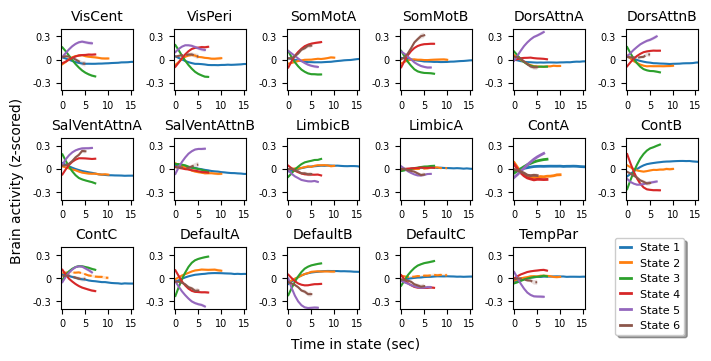

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(7, 3.5), layout='constrained')
axs = axs.flatten()
for j in range(len(cortex_groups)):
    ax = axs[j]
    for k in range(K):
        state = state_order[k]
        late_time = state_duration[state]+3
        mean_evolution = network_evolution[state][j][0:(late_time+1)]
        if rejection_mat[k, j] != 0:
            ax.plot(mean_evolution, label = 'State %s'%(k+1))
        else: 
            ax.plot(mean_evolution, ls = '--', label = 'State %s'%(k+1))
        se = np.zeros(len(mean_evolution))
        for t in range(len(mean_evolution)):
            vec = [network_evolution_subject[s][state][j][t] for s in range(num_subject)]
            se[t] = np.nanstd(vec)/np.sqrt(num_subject-np.sum(np.isnan(vec)))
        lower = mean_evolution-2*se
        upper = mean_evolution+2*se
        ax.fill_between(np.arange(len(se)), lower, upper, alpha=0.2)
        
        ax.set_ylim(-.4, .4)
        ax.set_yticks([0, .3], ['0', '0.3'])
        ax.set_title(cortex_key_labels[j], fontsize = 10)

        ax.set_yticks([-.3, 0, .3], ['-0.3', '0', '0.3'])

        label_times = [0,5,10,15] 
        xticks = [label_times[i]/0.72 for i in range(len(label_times))] # in TR
        ax.set_xticks(xticks, label_times)
        
        ax.set_xlim(-0.5, 21 + 0.5)

        ax.tick_params(axis='y', labelsize=7)   
        ax.tick_params(axis='x', labelsize=7)


fig.supxlabel('Time in state (sec)', fontsize = 10)
fig.supylabel('Brain activity (z-scored)', fontsize = 10)

for i in range(len(cortex_groups), len(axs)):
    axs[i].set_visible(False)

handles, labels = axs[10].get_legend_handles_labels()
for i in range(len(handles)):
    handles[i].set_linewidth(2)
    
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.92,0.35), fontsize = 8,
            fancybox=True, shadow=True, handlelength = 1)

Figure 9: network activity time subcortex (S2)

In [60]:
# use S2-level subcortical ROI grouping
subcortex_groups = [[1,2,5,28,29,32], 
                    [6,7,33,34],
                    [11,12,38,39],
                    [3,4,10,30,31,37],
                    [23,50], 
                    [8,9,35,36],
                    [21,48],
                    [22,49],
                    [26,53],
                    [27,54],
                    [13,14,40,41],
                    [15,16,42,43],
                    [24,51],
                    [25,52],
                    [19,20,46,47],
                    [17,18,44,45]
                    ]

for g in range(len(subcortex_groups)):
    subcortex_groups[g] =  np.array(subcortex_groups[g], dtype = int)-1

subcortex_key_labels = ['aHIP', 'pHIP','THA-DA', 'THA-VA', 'THA-DP', 'Tha-VP', 'lAMY', 'mAMY', 
                        'pGP','aGP', 'aPUT', 'pPUT', 'NAc-shell', 'NAc-core', 'pCAU', 'aCAU']

In [53]:
group_evolution = dict()
group_evolution_subject = dict()
for s in range(num_subject):
    group_evolution_subject[s] = dict()
for k in range(K):
    group_evolution[k] = [np.mean([activity_evolution[k][j] for j in subcortex_groups[i]], axis = 0) for i in range(len(subcortex_groups))]
    for s in range(num_subject):
        group_evolution_subject[s][k] = [np.mean([activity_evolution_subject[s][k][j] for j in subcortex_groups[i]], axis = 0) for i in range(len(subcortex_groups))] 

In [ ]:
state_auc = np.zeros((K, num_roi))
for k in range(K):
    state = state_order[k]
    state_auc[k,:] = compute_auc(activity_evolution[state])
state_auc_subcortex_group = np.zeros((K,len(subcortex_groups)))
for k in range(K):
    for i in range(len(subcortex_groups)):
        state_auc_subcortex_group [k,i] = np.mean(state_auc[k, subcortex_groups[i]])
        
state_auc_subcortex_group_subject = np.zeros((num_subject, K, 16))
for s in range(num_subject):
    state_auc_subject = np.zeros((K, num_roi))
    for k in range(K):
        state = state_order[k]
        state_auc_subject[k,:] = compute_auc(activity_evolution_subject[s][state], T = state_duration[state])
    for k in range(K):
        for i in range(16):
            state_auc_subcortex_group_subject[s,k,i] = np.mean(state_auc_subject[k, subcortex_groups[i]])

mu_0 = 0
pvalues = np.zeros((K, len(subcortex_groups)))
test_stats = np.zeros((K, len(subcortex_groups)))
for k in range(K):
    for i in range(len(subcortex_groups)):
        vec = [state_auc_subcortex_group_subject[s][k,i] for s in range(num_subject)]
        N = num_subject-np.sum(np.isnan(vec))  # number of subjects which have state k trajectories until mean duration (so auc is not nan)
        test_stats[k,i] = np.sqrt(N)*(np.nanmean(vec)-mu_0)/np.nanstd(vec)
        df = N-1
        pvalues[k,i] = 2*scipy.stats.t.sf(np.abs(test_stats[k,i]), df)
        
rejection_mat = np.zeros((K, len(subcortex_groups)))
for k in range(K):
    state = k
    for i in range(len(subcortex_groups)):
        if pvalues[state,i]<0.05/(K*len(subcortex_groups)):
            if state_auc_subcortex_group[state][i]>0:
                rejection_mat[k,i] = 1
            elif state_auc_subcortex_group[state][i]<0:
                rejection_mat[k,i] = -1

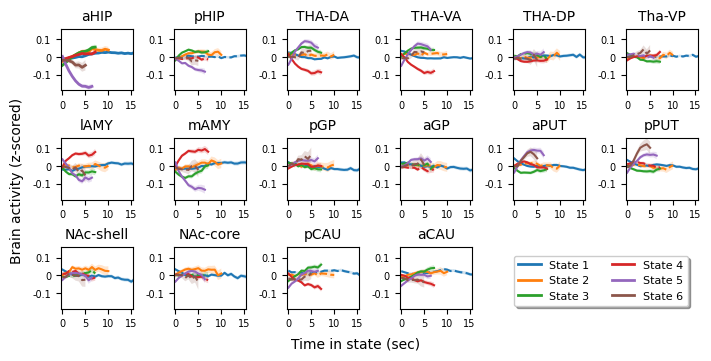

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(7, 3.5), layout='constrained')
axs = axs.flatten()
for j in range(len(subcortex_groups)):
    ax = axs[j]
    for k in range(K):
        state = state_order[k]
        late_time = state_duration[state]+3
        mean_evolution = group_evolution[state][j][0:(late_time+1)]
        if rejection_mat[k, j] != 0:
            ax.plot(mean_evolution, label = 'State %s'%(k+1))
        else: 
            ax.plot(mean_evolution, ls = '--', label = 'State %s'%(k+1))
        se = np.zeros(len(mean_evolution))
        for t in range(len(mean_evolution)):
            vec = [group_evolution_subject[s][state][j][t] for s in range(num_subject)]
            se[t] = np.nanstd(vec)/np.sqrt(num_subject-np.sum(np.isnan(vec)))
        lower = mean_evolution-2*se
        upper = mean_evolution+2*se
        ax.fill_between(np.arange(len(se)), lower, upper, alpha=0.2)

        label_times = [0,5,10,15] 
        xticks = [label_times[i]/0.72 for i in range(len(label_times))] # in TR
        ax.set_xticks(xticks, label_times)
        
        ax.set_xlim(-0.5, 21 + 0.5)

        ax.set_ylim(-.19, .16)
        ax.set_yticks([-0.1, 0, .1], ['-0.1','0', '0.1'])
        ax.set_title(subcortex_key_labels[j], fontsize = 10)

        ax.tick_params(axis='y', labelsize=7)   
        ax.tick_params(axis='x', labelsize=7)
        
fig.supxlabel('Time in state (sec)', fontsize = 10)
fig.supylabel('Brain activity (z-scored)', fontsize = 10)

for i in range(len(subcortex_groups), len(axs)):
    axs[i].set_visible(False)

handles, labels = axs[0].get_legend_handles_labels()

for i in range(len(handles)):
    handles[i].set_linestyle('-')
    handles[i].set_linewidth(2)

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.85,0.3), fontsize = 8,
            fancybox=True, shadow=True, ncols = 2, handlelength = 2)

Figure 10: network participation (heatmap)

In [64]:
# 17 network, cortex
cortex_groups = [[1,2,3,4,5,6, 101, 102, 103, 104, 105, 106], 
                 [7,8,9,10,11,12,107, 108, 109, 110, 111, 112], 
                 [13,14,15,16,17,18,19,20,113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123], 
                 [21, 22, 23, 24, 25, 26, 27, 28,124, 125, 126, 127, 128, 129, 130],
                 [29, 30, 31, 32, 33, 34,131, 132, 133, 134, 135, 136],
                 [35, 36, 37, 38, 39,137, 138, 139, 140, 141],
                 [40, 41, 42, 43, 44, 45, 46,142, 143, 144, 145, 146, 147, 148, 149, 150],
                 [47, 48, 49, 50,151, 152, 153, 154, 155, 156],
                 [51,52,157, 158, 159, 160],
                 [53, 54, 55, 56,161, 162, 163, 164],
                 [57, 58, 59, 60, 61, 62, 63, 64, 65, 66,165, 166, 167, 168, 169, 170],
                 [67, 68, 69, 70, 71,171, 172, 173, 174, 175, 176, 177, 178, 179, 180],
                 [72, 73, 74,181, 182, 183],
                 [75, 76, 77, 78, 79, 80, 81, 82,184, 185, 186, 187, 188, 189], 
                 [83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95,190, 191, 192, 193], 
                 [96, 97, 98,194, 195, 196],
                 [99,100,197, 198, 199, 200]]
for g in range(len(cortex_groups)):
    cortex_groups[g] = [cortex_groups[g][i]+54 for i in range(len(cortex_groups[g]))]
cortex_key_labels = ['VisCent','VisPeri','SomMotA','SomMotB','DorsAttnA','DorsAttnB', 'SalVentAttnA',
             'SalVentAttnB','LimbicB','LimbicA','ContA','ContB','ContC','DefaultA','DefaultB',
             'DefaultC','TempPar']
cortex_keys = np.cumsum([len(cortex_groups[g]) for g in range(len(cortex_groups))])[0:16]
cortex_keys = np.append(0, cortex_keys)
for g in range(len(cortex_groups)):
    cortex_groups[g] =  np.array(cortex_groups[g], dtype = int)-1

In [4]:
def compute_auc(activity_evolution, T = 5): # use T=5 for initial response
    num_roi = len(activity_evolution)
    auc = np.zeros(num_roi)
    for j in range(num_roi):
        auc[j] = np.mean(activity_evolution[j][1:(T+1)])-activity_evolution[j][0]
    return auc

In [65]:
state_auc = np.zeros((K, num_roi))
for k in range(K):
    state = state_order[k]
    state_auc[k,:] = compute_auc(activity_evolution[state])

state_auc_network = np.zeros((K,17))
for k in range(K):
    for i in range(17):
        state_auc_network[k,i] = np.mean(state_auc[k, cortex_groups[i]])

In [171]:
with open('summary_data/rejection_mat_cortical_network.pkl', 'rb') as f:
    rejection_mat = pickle.load(f)

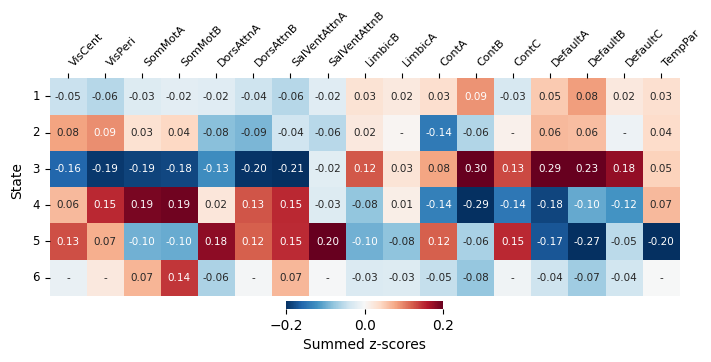

In [230]:
matrix = rejection_mat
annot_matrix = np.empty(matrix.shape, dtype=object)
for i in range(17):
    for k in range(K):
        if matrix[k,i] == 0:
            annot_matrix[k,i] = '-'
        else:
            annot_matrix[k,i] = f'{state_auc_network[k,i]:.2f}'

fig, axs = plt.subplots(figsize = (7,3.5), layout = 'constrained')
ax = axs
sns.heatmap(state_auc_network, yticklabels = ['%s'%(k+1) for k in range(K)], vmin = -.2, vmax = .2, 
            annot = annot_matrix, fmt='', annot_kws={'size': 7.5},
            xticklabels = cortex_key_labels, 
            cmap='RdBu_r', cbar=True, cbar_kws={"label": "Summed z-scores","shrink": 0.25, 'orientation': 'horizontal', 'pad': 0.02})
plt.yticks(rotation=0, fontsize = 8.5) 
ax = axs
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xticklabels(ax.get_xticklabels(), 
                   rotation=45,      
                   ha='left',        
                   va='bottom')   
plt.xticks(fontsize = 8)
fig.supylabel('State', fontsize = 10)
plt.show()
fig.savefig("Fig/heatmap.pdf", format = 'pdf', dpi = 300, bbox_inches='tight')

Figure 11: polar plot of network participation by state

In [62]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

In [66]:
state_auc_network_subject = np.zeros((num_subject, K, 17))
for s in range(num_subject):
    state_auc_subject = np.zeros((K, num_roi))
    for k in range(K):
        state = state_order[k]
        state_auc_subject[k,:] = compute_auc(activity_evolution_subject[s][state])
    for k in range(K):
        for i in range(17):
            state_auc_network_subject[s,k,i] = np.mean(state_auc_subject[k, cortex_groups[i]])
# SE across subjects for error bar
state_auc_se = np.zeros((K,17))
for k in range(K):
    for i in range(17):
        state_auc_se[k,i] = np.nanstd(state_auc_network_subject[:,k,i])/np.sqrt(num_subject-np.sum(np.isnan(state_auc_network_subject[:,k,i])))

In [ ]:
fig = make_subplots(rows=1, cols=3, specs=[[{'type': 'polar'} for k in range(3)]])

theta = cortex_key_labels

for k in range(3):
    r_values = state_auc_network[k,:]
    
    fig.add_trace(go.Scatterpolar(
        r=r_values - 2*state_auc_se[k,:],
        theta=theta,
        mode='lines',
        line = dict(color='black', width = .5)),row=1, col=k+1)

    fig.add_trace(go.Scatterpolar(
        r=r_values + 2*state_auc_se[k,:],
        theta=theta,
        mode='lines',
        fill='tonext',  
        fillcolor='grey', 
        line = dict(color='black', width = .5)),row=1, col=k+1)
    
    fig.add_trace(go.Scatterpolar(
        r=r_values,
        theta=theta,
        mode = "lines+markers",
        #fill='none',
        line=dict(color='black', width = 2)),row=1, col=k+1)

    # add a threshold trace or trace of zeros/baselines
    fig.add_trace(go.Scatterpolar(
        r=np.zeros((len(r_values))),
        theta=theta,
        fill='none',
        line=dict(color='green', width = 1),
        marker=dict(opacity=0)),row=1, col=k+1)
    
# set common range
fig.update_polars(radialaxis=dict(range=[-.35, .35],
                                tickmode='linear', dtick=0.1),
                  radialaxis_tickfont_size=12,
                  angularaxis_tickfont_size=15),

fig.update_layout(
showlegend=False,
)

# import plotly.io as pio
# pio.write_image(fig, "Fig/polar_plot/state1-3.pdf", width = 1400, height=500, scale = 1)

fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=3, specs=[[{'type': 'polar'} for k in range(3)]])

theta = cortex_key_labels

for k in range(3):
    r_values = state_auc_network[k+3,:]
    
    fig.add_trace(go.Scatterpolar(
        r=r_values - 2*state_auc_se[k+3,:],
        theta=theta,
        mode='lines',
        line = dict(color='black', width = .5)),row=1, col=k+1)

    fig.add_trace(go.Scatterpolar(
        r=r_values + 2*state_auc_se[k+3,:],
        theta=theta,
        mode='lines',
        fill='tonext',  
        fillcolor='grey', 
        line = dict(color='black', width = .5)),row=1, col=k+1)
    
    fig.add_trace(go.Scatterpolar(
        r=r_values,
        theta=theta,
        mode = "lines+markers",
        #fill='none',
        line=dict(color='black', width = 2)),row=1, col=k+1)

    # add a threshold trace or trace of zeros/baselines
    fig.add_trace(go.Scatterpolar(
        r=np.zeros((len(r_values))),
        theta=theta,
        fill='none',
        line=dict(color='green', width = 1),
        marker=dict(opacity=0)),row=1, col=k+1)
    
# set common range
fig.update_polars(radialaxis=dict(range=[-.35, .35],
                                tickmode='linear', dtick=0.1),
                  radialaxis_tickfont_size=12,
                  angularaxis_tickfont_size=15),

fig.update_layout(
showlegend=False,
)

# pio.write_image(fig, "Fig/polar_plot/state4-6.pdf", width = 1400, height=500, scale = 1)

fig.show()

Figure 13: network activation changes during transitions (cortex)

In [5]:
window_length = 20
time_to_transition = np.array(window_length/2, dtype = int)

In [4]:
with open('summary_data/transition_courses.pkl','rb') as f:
    transition_courses = pickle.load(f)
with open('summary_data/transition_courses_subject.pkl','rb') as f:
    transition_courses_subject = pickle.load(f)

In [6]:
# collect significant transitions
transitions_of_interest = []
K = 6
for k1 in range(K):
    for k2 in range(K):
        if len(transition_courses[k1][k2])>0:
            transitions_of_interest.append([k1, k2])
transitions_of_interest = np.array(transitions_of_interest)
num_transitions = transitions_of_interest.shape[0]

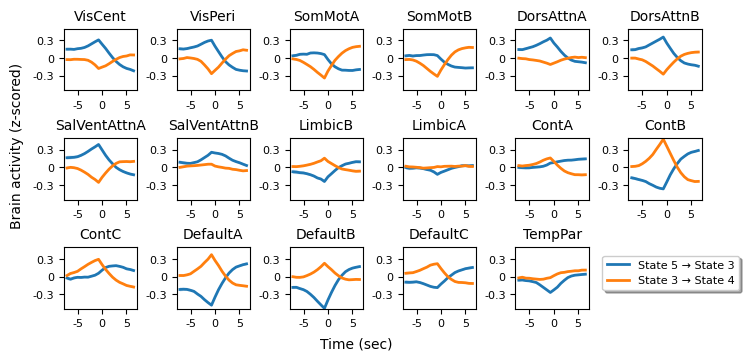

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(7, 3.5), layout='constrained')
axs = axs.flatten()

list = [7,4]
labels = ['State 5 → State 3', 'State 3 → State 4']

for i in range(2):
    
    k1 = transitions_of_interest[list[i],0]
    k2 = transitions_of_interest[list[i],1]

    network_evolution = transition_courses[k1][k2]
    network_evolution_subject = [transition_courses_subject[s][k1][k2] for s in range(num_subject)]

    for j in range(len(cortex_groups)):
        ax = axs[j]
        mean_evolution = network_evolution[j+8]
        ax.plot(mean_evolution, label = labels[i], linewidth = 2)
        se = np.zeros(window_length)
        for t in range(window_length):
            vec = [network_evolution_subject[s][j][t] for s in range(num_subject)]
            se[t] = np.nanstd(vec)/np.sqrt(num_subject-np.sum(np.isnan(vec)))
        lower = mean_evolution-2*se
        upper = mean_evolution+2*se
        ax.fill_between(np.arange(len(se)), lower, upper, alpha=0.2)

        ax.set_ylim(-.55, .5)
        ax.set_title(cortex_key_labels[j], fontsize = 10)
        ax.set_yticks([-.3, 0, .3], ['-0.3', '0', '0.3'], fontsize = 8)

        label_times = [-5,0,5] 
        xticks = [time_to_transition + label_times[i]/0.72 for i in range(len(label_times))] # in TR
        ax.set_xticks(xticks, [-5, 0, 5], fontsize = 8)

for i in range(len(cortex_groups), len(axs)):
    axs[i].set_visible(False)

fig.supxlabel('Time (sec)', fontsize = 10)
fig.supylabel('Brain activity (z-scored)', fontsize = 10, y = 0.6)

handles, labels = axs[0].get_legend_handles_labels()

for i in range(len(handles)):
    handles[i].set_linewidth(2)

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.95, 0.3), 
            fancybox=True, shadow=True, fontsize = 8)

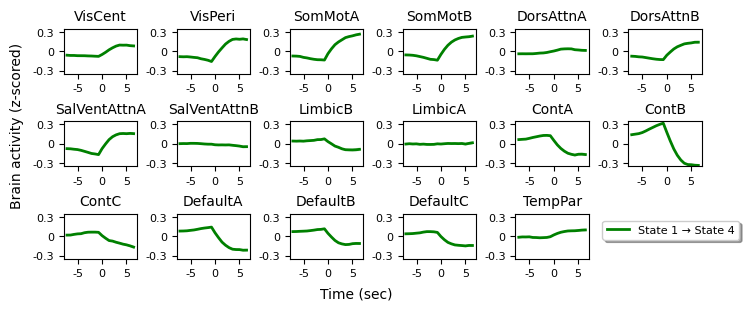

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(7,3), layout='constrained')
axs = axs.flatten()
    
k1 = 0
k2 = 3

network_evolution = transition_courses[k1][k2]
network_evolution_subject = [transition_courses_subject[s][k1][k2] for s in range(num_subject)]

for j in range(len(cortex_groups)):
    ax = axs[j]
    mean_evolution = network_evolution[j+8]
    ax.plot(mean_evolution, label = 'State 1 → State 4', color = 'green', linewidth = 2)
    se = np.zeros(window_length)
    for t in range(window_length):
        vec = [network_evolution_subject[s][j][t] for s in range(num_subject)]
        se[t] = np.nanstd(vec)/np.sqrt(num_subject-np.sum(np.isnan(vec)))
    lower = mean_evolution-2*se
    upper = mean_evolution+2*se
    ax.fill_between(np.arange(len(se)), lower, upper, alpha=0.2, facecolor = 'green')

    ax.set_ylim(-.35, .35)
    ax.set_title(cortex_key_labels[j], fontsize = 10)
    ax.set_yticks([-.3, 0, .3], ['-0.3', '0', '0.3'], fontsize = 8)

    label_times = [-5,0,5] 
    xticks = [time_to_transition + label_times[i]/0.72 for i in range(len(label_times))] # in TR
    ax.set_xticks(xticks, [-5, 0, 5], fontsize = 8)

for i in range(len(cortex_groups), len(axs)):
    axs[i].set_visible(False)

fig.supxlabel('Time (sec)', fontsize = 10)
fig.supylabel('Brain activity (z-scored)', fontsize = 10, y = 0.6)
# fig.suptitle('State 1 → State 4', fontsize = 12)

handles, labels = axs[0].get_legend_handles_labels()

for i in range(len(handles)):
    handles[i].set_linewidth(2)

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.95, 0.3), 
            fancybox=True, shadow=True, fontsize = 8)

Figure 14: region importance

In [25]:
with open('summary_data/importance_evolution.pkl','rb') as f:
   Qs = pickle.load(f)

In [26]:
importance_map = np.zeros((K, 254))
for k in range(K):
    state = state_order[k]
    importance_map[k,:] = Qs[state, state_duration[state]+3]

In [47]:
with open('cortical_roi_names.pkl','rb') as f:
   cortical_roi_names = pickle.load(f)
with open('subcortical_roi_names.pkl','rb') as f:
   subcortical_roi_names = pickle.load(f)
roi_names = subcortical_roi_names + cortical_roi_names

In [31]:
top_roi_importance = []
top_roi_idx_importance = []
K = 6
for k in range(K):
    state = state_order[k]
    vec = Qs[state, state_duration[state]+3]
    roi_idx = np.argsort(vec)[::-1][0:5] 
    top_roi_idx_importance.append(roi_idx)
    top_region_names = [roi_names[roi_idx[i]] for i in range(5)]
    top_roi_importance.append(top_region_names)

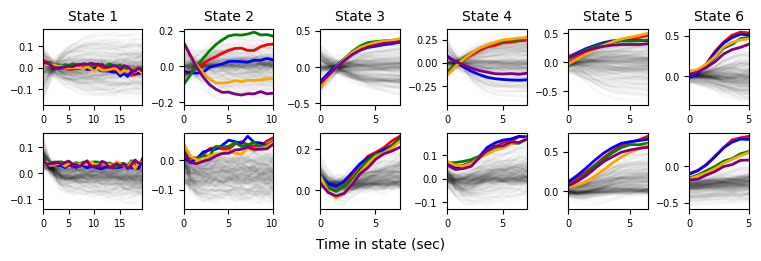

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=K, figsize = (7.5,2.5), width_ratios= [5,4.5,4,4,4,3], layout = 'constrained')
colors = ['red', 'blue', 'green', 'orange', 'purple']
for k in range(K):
    state = state_order[k]
    late_time = state_duration[state]+3

    ax = axs[0, k]

    # activity
    for j in range(254):
        ax.plot(activity_evolution[state][j][0:(late_time+1)], color='k',  alpha=0.02)
    for j in range(5):
        ax.plot(activity_evolution[state][top_roi_idx_importance[k][j]][0:(late_time+1)], color = colors[j], linewidth = 2)

    ax.tick_params(axis='y', labelsize=7)   
    ax.tick_params(axis='x', labelsize=7)  
    ax.set_title('State %s'%(k+1), fontsize = 10)

    if late_time > (10/0.72):
        if late_time > (15/0.72):
            xticklabels = [0, 5, 10, 15]
        else:
            xticklabels = [0, 5, 10] 
    else: 
        xticklabels = [0, 5] 
    
    xticks = [xticklabels[i]/0.72 for i in range(len(xticklabels))] # in TR
    ax.set_xlim(0, late_time)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    ax = axs[1, k]

    # importance
    ax.plot(Qs[state,0:(late_time+1),:], color='k', alpha=0.02)
    for j in range(5):
        ax.plot(Qs[state,0:(late_time+1), top_roi_idx_importance[k][j]], color = colors[j], label = roi_names[top_roi_idx_importance[k][j]], linewidth = 2)
    # ax.set_title('State %s'%(k+1))

    xticks = [xticklabels[i]/0.72 for i in range(len(xticklabels))] # in TR
    ax.set_xlim(0,late_time)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    ax.tick_params(axis='y', labelsize=7)   
    ax.tick_params(axis='x', labelsize=7)

fig.supxlabel('Time in state (sec)', fontsize = 10)

handles = dict()
labels = dict()
for k in range(K):
    ax = axs[1,k]
    handles[k], labels[k] = ax.get_legend_handles_labels()
    
# plt.savefig('Fig/region_importance_temporal_plot.pdf', bbox_inches='tight')

Text(0.02, 0.5, 'Top-5 ROIs')

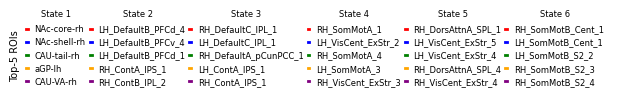

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=K, figsize = (6,1), layout = 'constrained') 
for k in range(K):
    ax = axs[k]
    ax.set_title('State %s'%(k+1), fontsize = 6)
    ax.legend(handles[k], labels[k], loc='upper center', frameon=False, bbox_to_anchor=(0.5, 1.1), fontsize = 6,  handlelength=0.2)
    ax.axis('off')
# fig.supylabel('Top-5 ROIs', fontsize = 7)
# plt.savefig('Fig/region_importance_temporal_legend.pdf', bbox_inches='tight')

In [45]:
roi_list = np.array([77, 80, 75, 84])-1 + 54
roi_label = ['PCC (DefaultA)', 'vmPFC (DefaultA)', 'angular gyrus (DefaultA)', 'temporal lobe (DefaultB)']

In [49]:
[roi_names[roi_list[i]] for i in range(4)]

['LH_DefaultA_pCunPCC_1',
 'LH_DefaultA_PFCm_1',
 'LH_DefaultA_IPL_1',
 'LH_DefaultB_Temp_2']

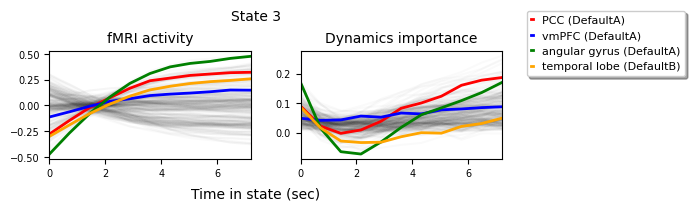

In [156]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (5,2),  layout='constrained', gridspec_kw={'wspace': 0.1})

colors = ['red', 'blue', 'green', 'orange']
k = 2
state = state_order[k]
late_time = state_duration[state]+3

ax = axs[0]
for j in range(254):
    ax.plot(activity_evolution[state][j][0:(late_time+1)], color='k', alpha=0.02)
for j in range(len(roi_list)):
    ax.plot(activity_evolution[state][roi_list[j]][0:(late_time+1)], color = colors[j], label = roi_label[j], linewidth = 2)

if late_time > (10/0.72):
        if late_time > (15/0.72):
            xticklabels = [0, 5, 10, 15]
        else:
            xticklabels = [0, 5, 10] 
else: 
    xticklabels = [0, 2, 4, 6] 
xticks = [xticklabels[i]/0.72 for i in range(len(xticklabels))] # in TR
ax.set_xlim(0, late_time)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.tick_params(axis='y', labelsize=7)   
ax.tick_params(axis='x', labelsize=7)
ax.set_title('fMRI activity', fontsize = 10)
    
ax = axs[1]
ax.plot(Qs[state,0:(late_time+1),:], color='k', alpha=0.02)
for j in range(len(roi_list)):
    ax.plot(Qs[state,0:(late_time+1), roi_list[j]], color = colors[j], linewidth = 2)

ax.set_xlim(0, late_time)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.tick_params(axis='y', labelsize=7)   
ax.tick_params(axis='x', labelsize=7)
ax.set_title('Dynamics importance', fontsize = 10)

fig.supxlabel('Time in state (sec)', fontsize = 10)
fig.suptitle('State 3', fontsize = 10)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.2, 1),
            fancybox=True, shadow=True, fontsize = 8, handlelength=0.2)
plt.savefig('Fig/activity_vs_importance_state3.pdf', bbox_inches='tight')

In [ ]:
# with open('summary_data/region_importance_rejection_mat.pkl','rb') as f:
#    rejection_mat = pickle.load(f)
# np.sum(rejection_mat[state_order, 0:54], axis = 1)

array([48, 11,  0,  2,  0,  0])

In [13]:
atlas = load_img('Schaefer2018_200Parcels_7Networks_order_Tian_Subcortex_S4_MNI152NLin6Asym_2mm.nii.gz')
def vec_to_img(vec):
    n_rois = 254
    atlas_data = atlas.get_fdata()

    vec_img_data = np.zeros_like(atlas_data)
    for idx_roi in range(n_rois):
        vec_img_data += (atlas_data==idx_roi+1) * vec[idx_roi]

    vec_img = new_img_like(data=vec_img_data, ref_niimg=atlas)
    return vec_img

In [20]:
vec = np.zeros(254)
vec[top_roi_idx_importance[0]] =  importance_map[0, top_roi_idx_importance[0]]
vec_img = vec_to_img(vec)
vec_img.to_filename(f'maps/top-10-regions/importance/subcortex/state1.nii.gz')

In [ ]:
display_mode = "z"
cut_coords = [5]
cmap = 'seismic'
threshold = 1e-10
colorbar = True 
cbar_tick_format = "%.2f" 
dim = 0
draw_cross = False 
annotate = False 
black_bg = False
dpi = 300
width = 4
height = 4

In [23]:
vmaxs = np.max(importance_map, axis = 1)
vmins = -vmaxs

In [50]:
modes = ['y', 'z']
coordinates = [-12, 5]
overlay = image.load_img('maps/top-10-regions/importance/subcortex/state1.nii.gz')

for i in range(len(modes)):
    display_mode = modes[i]
    cut_coords = [coordinates[i]]

    fig,ax = plt.subplots(1,1)
    plotting.plot_stat_map(
        overlay, 
        bg_img=underlay, 
        cut_coords=cut_coords, 
        display_mode=display_mode,
        colorbar=False, 
        cbar_tick_format=cbar_tick_format,
        threshold=threshold,
        annotate=annotate, 
        draw_cross=draw_cross, 
        black_bg=False, 
        cmap=cmap, 
        symmetric_cbar='auto', 
        dim=dim,
        vmax=vmaxs[0],
        vmin=vmins[0],
        figure=fig,
        axes=ax,
    )
    fig.set_size_inches(width, height) 
    out_path = "maps/top-10-regions/importance/subcortex/%s=%s.jpg"%(display_mode,coordinates[i])
    fig.savefig(out_path,dpi=dpi,transparent=True) 
    trim(Image.open(out_path)).save(out_path, dpi=(dpi,dpi))
    plt.close()

Figure 15: transition importance

In [ ]:
with open('summary_data/transition_importance_time_subject.pkl','rb') as f:
    transition_importance_time_subject = pickle.load(f)

In [14]:
t_list = np.arange(-5,7)
num_subject = 500

In [16]:
with open('summary_data/transition_importance_subject.pkl','rb') as f:
    transition_importance_subject = pickle.load(f)
importance_map = np.nanmean(transition_importance_subject, axis = 0)

In [19]:
top_roi_importance = []
top_roi_idx_importance = []
for i in range(num_transitions):
    vec = importance_map[i, :]
    roi_idx = np.argsort(vec)[::-1][0:5] 
    top_roi_idx_importance.append(roi_idx)
    top_region_names = [roi_names[roi_idx[i]] for i in range(5)]
    top_roi_importance.append(top_region_names)

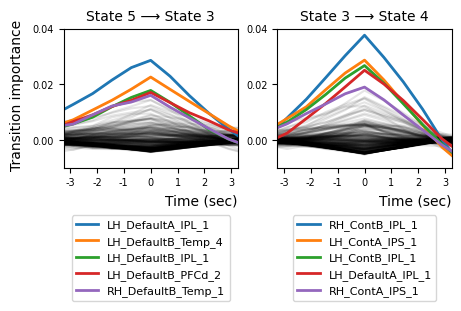

In [34]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (4.5,3), layout = 'constrained', gridspec_kw={'wspace': 0})
axs = axs.flatten()
final_list = [7,4]
for i in range(2):
    ax = axs[i]
    for j in range(254):
        ax.plot(t_list, np.nanmean(transition_importance_time_subject[:,final_list[i],:,j], axis = 0), color = 'k', alpha = 0.1)
    for j in range(5):
        ax.plot(t_list, np.nanmean(transition_importance_time_subject[:,final_list[i],:,top_roi_idx_importance[final_list[i]][j]], axis = 0), label = top_roi_importance[final_list[i]][j], linewidth = 2)
    
    ax.set_yticks([0,0.02,0.04])
    ax.set_ylim(-0.01,0.04)
    ax.set_title('State %s ⟶ State %s'%(transitions_of_interest[final_list[i],0] + 1, transitions_of_interest[final_list[i],1] + 1), fontsize = 10)
    

    label_times = [-3,-2,-1,0,1,2,3] 
    xticks = [label_times[i]/0.72 for i in range(len(label_times))] # in TR
    ax.set_xticks(xticks, [-3,-2,-1,0,1,2,3])
    ax.set_xlim(-4.5,4.5)

    ax.tick_params(axis='y', labelsize=7)   
    ax.tick_params(axis='x', labelsize=7)

    ax.set_xlabel('Time (sec)', loc='right', fontsize = 10)

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), fontsize = 8)

for i in range(num_transitions, len(axs)):
    axs[i].set_visible(False)

fig.supylabel('Transition importance', y=0.7, fontsize = 10)

plt.savefig('Fig/ti_timecourse_result.pdf', bbox_inches='tight')

Supplementary

Figure S3: temporal activity for cortical networks during significant transitions.

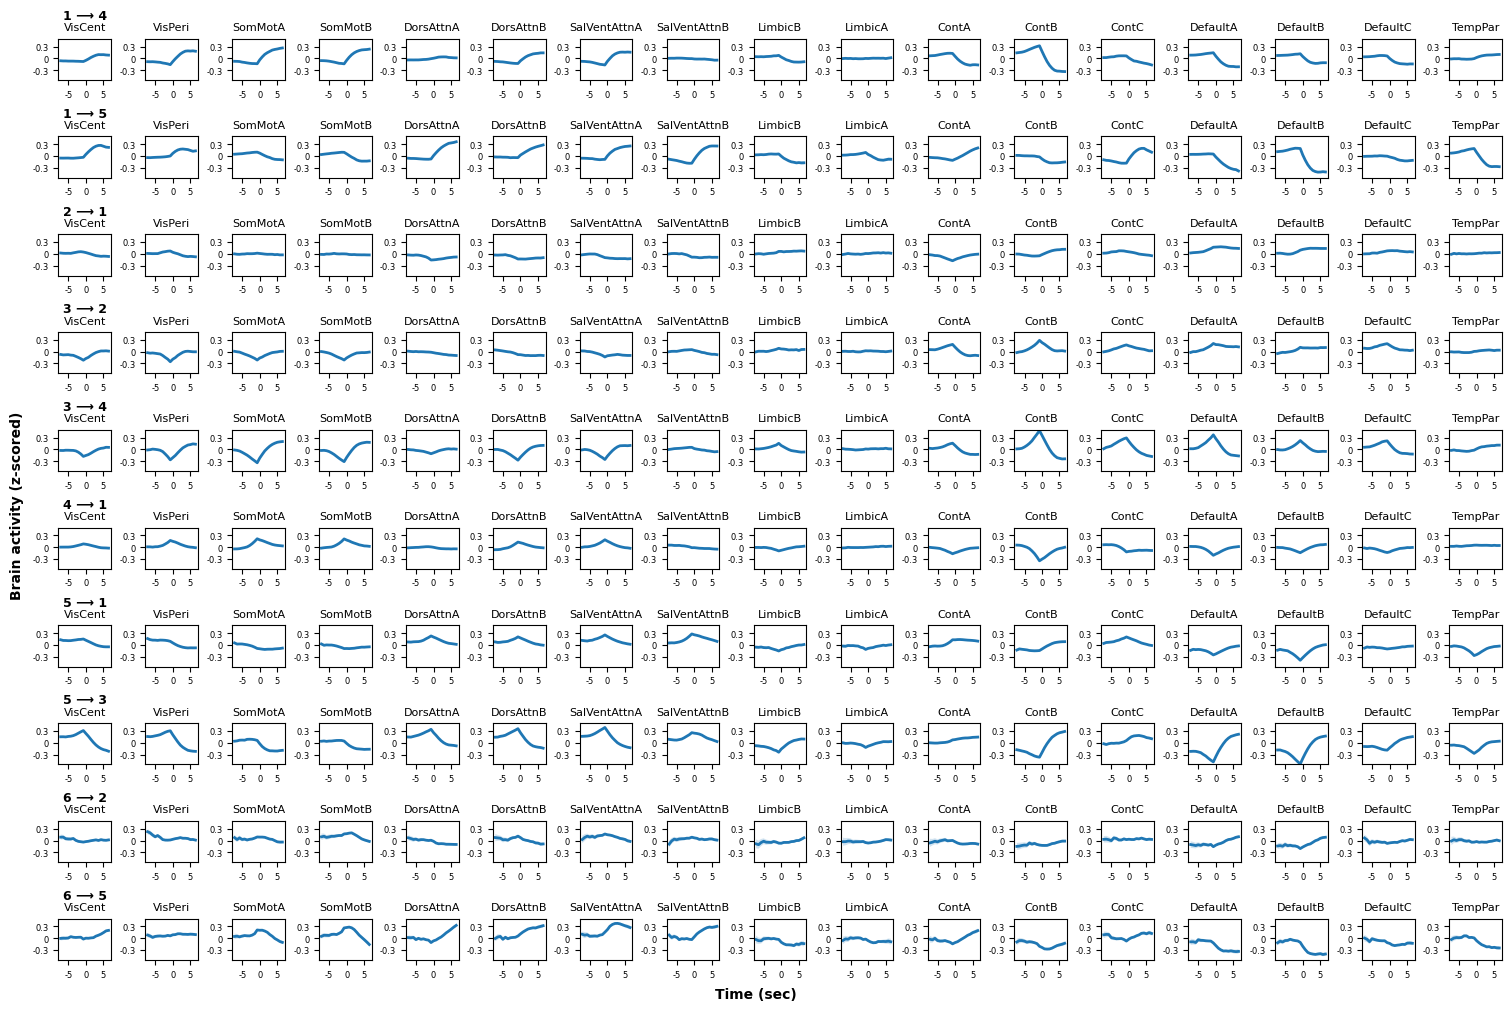

In [30]:
fig, axs = plt.subplots(nrows=num_transitions, ncols=17, figsize=(15, num_transitions), layout='constrained')
for i in range(num_transitions):
    k1 = transitions_of_interest[i,0]
    k2 = transitions_of_interest[i,1]

    network_evolution = transition_courses[k1][k2]
    network_evolution_subject = [transition_courses_subject[s][k1][k2] for s in range(num_subject)]

    for j in range(len(cortex_groups)):
        ax = axs[i, j]
        mean_evolution = network_evolution[j+8]
        ax.plot(mean_evolution, linewidth = 2)
        se = np.zeros(window_length)
        for t in range(window_length):
            vec = [network_evolution_subject[s][j][t] for s in range(num_subject)]
            se[t] = np.nanstd(vec)/np.sqrt(num_subject-np.sum(np.isnan(vec)))
        lower = mean_evolution-2*se
        upper = mean_evolution+2*se
        ax.fill_between(np.arange(len(se)), lower, upper, alpha=0.2)

        ax.set_ylim(-.55, .5)
        ax.set_title(cortex_key_labels[j], fontsize = 8)
        ax.set_yticks([-.3, 0, .3], ['-0.3', '0', '0.3'])
        
        label_times = [-5,0,5] 
        xticks = [time_to_transition + label_times[i]/0.72 for i in range(len(label_times))] # in TR
        ax.set_xticks(xticks, [-5, 0, 5])

        ax.tick_params(axis='y', labelsize=6)   
        ax.tick_params(axis='x', labelsize=6)

fig.supxlabel('Time (sec)', fontsize = 10, fontweight='bold')
fig.supylabel('Brain activity (z-scored)', fontsize = 10, fontweight='bold')

row_titles = ['%s ⟶ %s'%(transitions_of_interest[i,0] + 1, transitions_of_interest[i,1] + 1) for i in range(num_transitions)]

for i, ax_row in enumerate(axs):
    middle_ax = ax_row[0]
    middle_ax.text(.5, 1.4, row_titles[i], 
                   transform=middle_ax.transAxes,
                   fontsize=9, fontweight='bold',
                   va='bottom', ha='center')
    
fig.savefig("Fig/transition_courses_supp.pdf", bbox_inches='tight')

Fig.S5

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = (14,5), layout = 'constrained', gridspec_kw={'wspace': 0.05})
axs = axs.flatten()
for i in range(num_transitions):
    ax = axs[i]
    for j in range(254):
        ax.plot(t_list, np.nanmean(transition_importance_time_subject[:,i,:,j], axis = 0), color = 'k', alpha = 0.1)
    for j in range(5):
        ax.plot(t_list, np.nanmean(transition_importance_time_subject[:,i,:,top_roi_idx_importance[i][j]], axis = 0), label = top_roi_importance[i][j], linewidth = 2)
    
    ax.set_title('%s ⟶ %s'%(transitions_of_interest[i,0] + 1, transitions_of_interest[i,1] + 1))
    ax.legend(loc='upper center', bbox_to_anchor=(0.4, -0.2), fontsize = 8)
    ax.set_xlabel('Time(s)', loc='right')
    ax.xaxis.set_label_coords(1.05, -0.25)

    label_times = [-3,-2,-1,0,1,2,3] 
    xticks = [label_times[i]/0.72 for i in range(len(label_times))] # in TR
    ax.set_xticks(xticks, [-3,-2,-1,0,1,2,3])
    ax.set_xlim(-4.5,4.5)

for i in range(num_transitions, len(axs)):
    axs[i].set_visible(False)

fig.supylabel('Transition Importance', y = 0.6, fontsize = 12)